# Homework 5: 

In [6]:

import cmath
import math
from scipy.integrate import odeint
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
import pandas as pd, numpy as np
from scipy.stats import norm
from scipy.integrate import odeint
from scipy import optimize
from scipy import integrate
from IPython.display import display, Math, Latex
import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt

# Read PSA MeasureData from figure 2

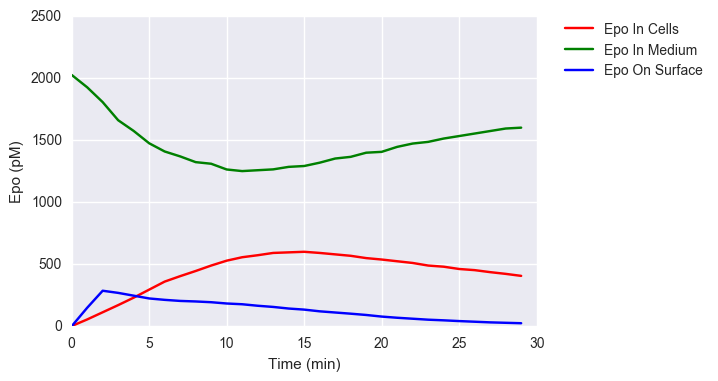

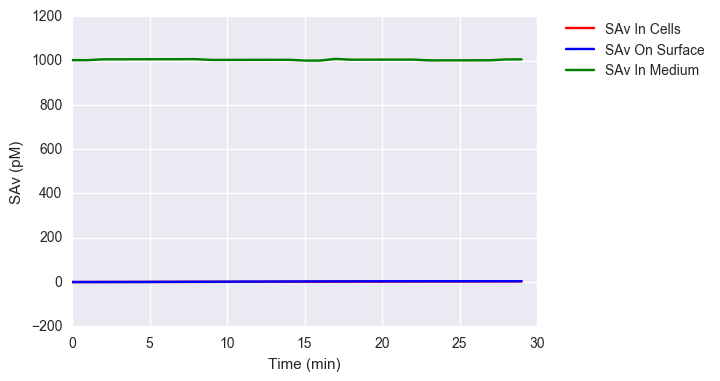

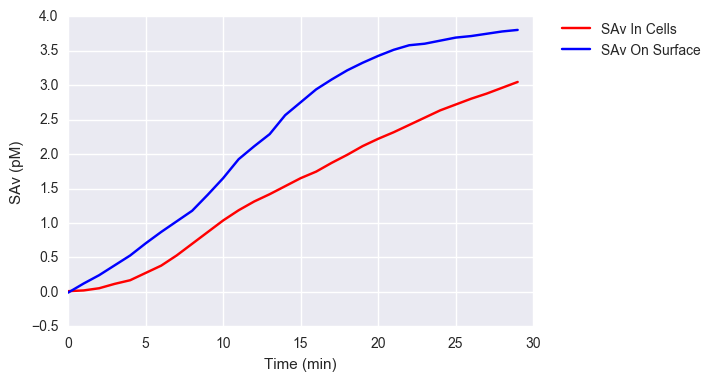

In [9]:
time = [i for i in range(30)]
epoInCells = pd.read_csv("EpoInCells.csv")["Concentration"].values
epoInMedium = pd.read_csv("EpoInMedium.csv")["Concentration"].values
epoOnSurface = pd.read_csv("EpoOnSurface.csv")["Concentration"].values
SAvInCells = pd.read_csv("SAvInCells30.csv")["Concentration"].values
SAvInMedium = pd.read_csv("SAvInMedium30.csv")["Concentration"].values
SAvOnSurface = pd.read_csv("SAvOnSurface30.csv")["Concentration"].values

d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface}
obsEpo = pd.DataFrame(data=d, index=time)
d= {'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface}
obsSAv = pd.DataFrame(data=d, index=time)
d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface, 
    'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface,
    'expSAv': [999.293],
    'expEpo': [2030.19]}
obsDF = pd.DataFrame(data=d, index=time)


plt1 = plt.plot(time,epoInCells , 'r-', label="Epo In Cells")
plt2 = plt.plot(time,epoInMedium, 'g-', label="Epo In Medium")
plt3 = plt.plot(time,epoOnSurface, 'b-', label="Epo On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('Epo (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt2 = plt.plot(time,SAvInMedium, 'g-', label="SAv In Medium")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

# Get Column Stack for PS and COMP_PS

In [26]:
import numpy as np
def ColStack(b):
    ## *****************************NOTE: np.ceil not used 
    x = []
    
    expSAv = 999.293
    expEpo = 2030.19
    for i in range(1,9):
        x.append(np.random.uniform(1e-7, 1e3, [b,1]))
    epop10 = expEpo + expEpo*.1
    epom10 = expEpo - expEpo*.1
    SAvp10 = expSAv + expSAv*.1
    SAvm10 = expSAv - expSAv*.1
    x.append(np.random.uniform(epom10, epop10, [b,1]))
    x.append(np.random.uniform(SAvm10, SAvp10, [b,1]))
   
    return np.column_stack(x)

# Sobol

In [28]:
def Sobol_obj(par):
    KD = 129
    KD_SAv = 76
    Bmax = 2500
    Bmax_SAv = 2964
    
    def core(y, t, params):
    #    
        KD = 129
        Bmax = 2500

        x1,x2,x3,x4,x5,x6 = y
        kt,kon,ke,kex,kdi,kde = params
        koff = kon*KD
        return [
            kt*Bmax - kt*x1 - kon*x1*x2 + koff*x3 + kex*x4,
            -kon*x1*x2 + koff*x3 + kex*x4,
            kon*x1*x2 - koff*x3 - ke*x3,
            ke*x3 - kex*x4 - kdi*x4 - kde*x4,
            kdi*x4,
            kde*x4
        ]
    def aux(y, t, params):
        #print y
        KD_SAv = 76
        Bmax_SAv = 2964
        x7,x8,x9,x10,x11,x12 = y
        kt,kon_SAv,kex_SAv,kdi,kde = params
        koff_SAv = kon_SAv*KD_SAv
        return [
            kt*Bmax_SAv - kt*x7 - kon_SAv*x7*x8 + koff_SAv*x9,
            -kon_SAv*x7*x8 + koff_SAv*x9 + kex_SAv*x10,
            kon_SAv*x7*x8 - koff_SAv*x9 - kt*x9,
            kt*x9 - kex_SAv*x10 - kdi*x10 - kde*x10,
            kdi*x10,
            kde*x10      
        ]
    
    ### yca contains all initial values for core and aux systems
    ### 
    ### yca is divided into yc0 and ya0 (the initial values 
    ### for core and aux systems respectively)
    ### 
    ### yc0 and ya0 are updated through the ODE step process
    ###
    ### params contains all parameters for core and aux models
    ### params = (shared vars) (aux only vars)   (core only vars)
    ### params = kt,kdi,kde,kon_SAv,kex_Sav,kmob,kon,ke,kex
    ### auxparams = (aux vars)
    ### coreparams = (core vars)
    #unpack Model Params and Initial Conditions
    xy0 = [Bmax,0,0,0,0,Bmax_SAv,0,0,0,0]
    t = range(30)
    params = par[:8]
    yca=[]
    yca = np.append(xy0[0],par[8])
    yca = np.append(yca,xy0[1:6])
    yca = np.append(yca,par[9])
    yca = np.append(yca,xy0[6:])
    yc0 = yca[:6]
    ya0 = yca[6:]
    
    kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex = params
    auxparams = [kt,kon_SAv,kex_Sav,kdi,kde]
    coreparams = [kt,kon,ke,kex,kdi,kde]
    
    output = []
    ti = [0,1]
    output.append(np.append(yc0,ya0))
    index = 0    
    for idx in range(len(t)-1):        
        
        
        # Solve
        yc = odeint(core, yc0, ti, args=(coreparams,))
        ya = odeint(aux, ya0, ti, args=(auxparams,))
        # Extract values for end of step
        resc = yc[1]
        resa = ya[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        output.append(np.append(resc,resa))
        yc0 = resc
        ya0 = resa
        # Update initial conditions for next step
        index += 1
    
    yT = np.array(output).T
    sim = []
    sim.append(yT[3]+yT[4])
    sim.append(yT[1] + yT[5])
    sim.append(yT[2])
    sim.append(yT[9]+yT[10])
    sim.append(yT[7]+yT[11])
    sim.append(yT[8])
    names = list(obsDF.columns.values)
    mysum = 0
    for i in range(len(sim)):
        mysum += np.sum(sim[i]-obsDF[names[i]].values)**2
    return mysum

In [33]:
N=3000
kp = [1 for i in range(10)]
n_p = len(kp)
PS = []
comp_PS = []
n_base = math.ceil(N/n_p)

#PS=[np.ceil((1000*np.random.random((int(n_base),1))) + 1), np.ceil((10 + 90*np.random.random((int(n_base),1)))), np.ceil((1+ 10*np.random.random((int(n_base),1))))]
#comp_PS = [np.ceil((1000*np.random.random((int(n_base),1))) + 1), np.ceil((10 + 90*np.random.random((int(n_base),1)))), np.ceil((1+ 10*np.random.random((int(n_base),1))))]
PS = ColStack(int(n_base))
comp_PS = ColStack(int(n_base))

output = [[0] for i in range(int(n_base))]
c_out_1 = [[0] * n_p for i in range(int(n_base))]
c_out_t = [[0] * n_p for i in range(int(n_base))]

for i in range(int(n_base)):
    #kp = [PS[i][0],PS[i][1],PS[i][2]]
    kp = PS[i][:]
    output[i] = (Sobol_obj(kp))
    for j in range(int(n_p)):
        kp = np.append(comp_PS[i][0:j if j>0 else 0], PS[i][j])
        kp = np.append(kp, comp_PS[i][j+1:n_p])
        c_out_1[i][j] = Sobol_obj(kp)
        
        kp = np.append(PS[i][0:j if j>0 else 0], comp_PS[i][j])
        kp = np.append(kp, PS[i][j+1:n_p])
        c_out_t[i][j] = Sobol_obj(kp)

f0 = 0
D = 0
for i in range(int(n_base)):
    f0 = f0+output[i]/n_base
    D = D+(output[i]**2)/n_base

D=D-f0**2
Dj= [[D] for i in range(int(n_p))]
Dtotj= [[0] for i in range(int(n_p))]
    
for i in range(int(n_base)):
    for j in range(int(n_p)):
        Dj[j] = Dj[j] - ((output[i]-c_out_1[i][j])**2)/(2*n_base)
        Dtotj[j] = Dtotj[j] + ((output[i]-c_out_t[i][j])**2)/(2*n_base)
Dmat = [[D] for i in range(int(n_p))]
Sob_1 = np.divide(Dj,Dmat)
Sob_t = np.divide(Dtotj,Dmat)
#Sob_1 = Dj/(ones())

# Sobol Output

In [48]:
sens_ind = Sob_t
rank_sens = sorted(Sob_t)
rank_sens_p = sorted(range(len(Sob_t)), key=lambda x:Sob_t[x])
print "Sensitivity Rank"
names = ['kt','kdi','kde','kon_SAv','kex_Sav','kon','ke','kex','Epo','SAv']
for i in range(0,len(names)):
    print('%.2i: %s' % (i+1,names[rank_sens_p.index(i)]) )
print "n_p = ", n_p
print ''
print "D = ", D
print ""
print "Dj"
print('\n'.join('{}: {}'.format(*k) for k in enumerate(Dj)))
print ""

print "sens_ind"
print('\n'.join('{}: {}'.format(*k) for k in enumerate(sens_ind)))
print ""
print "rank_sens"
print('\n'.join('{}: {}'.format(*k) for k in enumerate(rank_sens)))
print ""
print "rank_sens_p"
print('\n'.join('{}: {}'.format(*k) for k in enumerate(rank_sens_p)))
print ""


Sensitivity Rank
01: kde
02: Epo
03: SAv
04: kdi
05: kt
06: kon
07: ke
08: kex_Sav
09: kex
10: kon_SAv
n_p =  10

D =  1.90341088522e+18

Dj
0: [  1.35112119e+17]
1: [  5.68652013e+17]
2: [  1.42005785e+18]
3: [  1.34366624e+17]
4: [  1.34065054e+17]
5: [  1.35883923e+17]
6: [  1.35766783e+17]
7: [  1.40657456e+17]
8: [  1.23450296e+17]
9: [  1.20747526e+17]

sens_ind
0: [ 0.00043186]
1: [ 0.2500017]
2: [ 0.71440119]
3: [  2.17547293e-06]
4: [  1.46403929e-06]
5: [ 0.00056374]
6: [ 0.00142784]
7: [ 0.00050816]
8: [ 0.00384288]
9: [ 0.0004813]

rank_sens
0: [  1.46403929e-06]
1: [  2.17547293e-06]
2: [ 0.00043186]
3: [ 0.0004813]
4: [ 0.00050816]
5: [ 0.00056374]
6: [ 0.00142784]
7: [ 0.00384288]
8: [ 0.2500017]
9: [ 0.71440119]

rank_sens_p
0: 4
1: 3
2: 0
3: 9
4: 7
5: 5
6: 6
7: 8
8: 1
9: 2

